In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from random import randint

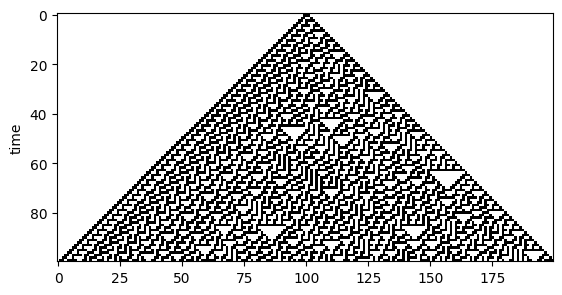

In [2]:
import cellpylib as cpl

# initialize a CA with 200 cells (a random initialization is also available) 
cellular_automaton = cpl.init_simple(200)

# evolve the CA for 100 time steps, using Rule 30 as defined in NKS
cellular_automaton = cpl.evolve(cellular_automaton, timesteps=100, memoize=True, 
                                apply_rule=lambda n, c, t: cpl.nks_rule(n, 30))

# plot the resulting CA evolution
cpl.plot(cellular_automaton)

In [3]:
import matplotlib.pyplot as plt
plt.imsave('ca.png', cellular_automaton, cmap='binary')

In [4]:
avg_cell_entropy = cpl.average_cell_entropy(cellular_automaton)
print('Average cell entropy: {:.3f}'.format(avg_cell_entropy))

Average cell entropy: 0.734


In [5]:
def run_ca(rule_number, show=False, validation=False):
    cellular_automaton = cpl.init_random(149)
    cellular_automaton = cpl.evolve(cellular_automaton, timesteps=149,
                                    apply_rule=lambda n, c, t: cpl.binary_rule(n, rule_number), r=3)
    if show:
        cpl.plot(cellular_automaton)
    avg_cell_entropy = cpl.average_cell_entropy(cellular_automaton)
    if validation:
        path = './val/' + str(rule_number)
    else:
        path = './img/' + str(rule_number) 
    Path(path).mkdir(parents=True, exist_ok=True)
    plt.imsave(path + '/' + str(avg_cell_entropy) + '.png', cellular_automaton, cmap='binary')
    print('Average cell entropy: {:.3f}'.format(avg_cell_entropy))
    return path + '/' + str(avg_cell_entropy) + '.png'

In [90]:
# from random import randint
# # make 10 random rules, and generate 10 images for each
# for i in range(10):
#     rule_number = randint(0, 10**36)
#     for j in range(10):
#         run_ca(rule_number)

In [6]:
import os 
# labels is a ndarray of shape (num_samples, 1)
labels = np.zeros((300, 36))
for folder in os.walk('./img'):
    for i, _file in enumerate(folder[2]):
        # append name of folder
        rule = folder[0].split('/')[1].split('\\')[1]
        # split rule into a vector of digits
        labels[i] = [int(rule[i]) if i < len(rule) else 0 for i in range(36)]
dataset = keras.preprocessing.image_dataset_from_directory("./img", image_size=(149, 149), batch_size=300, label_mode='int', labels=None)
# print dataset labels
imgs = []
for img in dataset:
    imgs.append(img)
imgs[0]

Found 388 files belonging to 1 classes.


<tf.Tensor: shape=(300, 149, 149, 3), dtype=float32, numpy=
array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [  0.,   0.,   0.],
         [255., 255., 255.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [  0.,   0.,   0.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [  0.,   0.,   0.]],

        ...,

        [[255., 255., 255.],
         [  0.,   0.,   0.],
         [255., 255., 255.],
         ...,
         [  0.,   0.,   0.],
         [255., 255., 255.],
         [  0.,   0.,   0.]],

        [[255., 255., 255.],
         [  0.,   0.,   0.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
       

In [8]:
from tensorflow.keras.layers import CenterCrop
from tensorflow.keras.layers import Rescaling
from tensorflow.keras import layers


inputs = keras.Input(shape=(None, None, 3))


# Center-crop images to 150x150
x = CenterCrop(height=150, width=150)(inputs)
# Rescale images to [0, 1]
x = Rescaling(scale=1.0 / 255)(x)

# Apply some convolution and pooling layers
# Add more for some "deep" learning
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3, 3))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)

# Apply global average pooling to get flat feature vectors
x = layers.GlobalAveragePooling2D()(x)

# # Add a dense classifier on top
# num_classes = 18
# outputs = layers.Dense(num_classes, activation="softmax")(x)

# Add some hidden layers for "deep" learning
for _ in range(10):
    x = layers.Dense(64, activation="relu")(x)


# Add a dense regressor on top
outputs = layers.Dense(36)(x)

In [9]:
model = keras.Model(inputs=inputs, outputs=outputs)
images = next(iter(dataset))
images = images/255.0
processed_data = model(images)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 center_crop_1 (CenterCrop)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 32)        9248      
                                                             

In [10]:
model.compile(optimizer=keras.optimizers.Adam(clipnorm=1, clipvalue=1, learning_rate=1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsolutePercentageError()])

In [11]:
# clear logs dir
import shutil
shutil.rmtree('./logs', ignore_errors=True)

In [12]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir="./logs"),
]
history = model.fit(imgs[0], labels, epochs=1500, callbacks=callbacks)

Epoch 1/1500
10/10 [==============================] - 4s 37ms/step - loss: 7.0595 - mean_absolute_percentage_error: 58810880.0000
Epoch 2/1500
10/10 [==============================] - 0s 15ms/step - loss: 5.9528 - mean_absolute_percentage_error: 807267840.0000
Epoch 3/1500
10/10 [==============================] - 0s 16ms/step - loss: 5.6369 - mean_absolute_percentage_error: 600840064.0000
Epoch 4/1500
10/10 [==============================] - 0s 16ms/step - loss: 5.5850 - mean_absolute_percentage_error: 975460672.0000
Epoch 5/1500
10/10 [==============================] - 0s 14ms/step - loss: 5.1889 - mean_absolute_percentage_error: 817497600.0000
Epoch 6/1500
10/10 [==============================] - 0s 15ms/step - loss: 5.2337 - mean_absolute_percentage_error: 821706368.0000
Epoch 7/1500
10/10 [==============================] - 0s 15ms/step - loss: 5.2096 - mean_absolute_percentage_error: 1021585024.0000
Epoch 8/1500
10/10 [==============================] - 0s 16ms/step - loss: 5.2657 -

In [13]:
# test a prediction on an image in the training set
test_img = imgs
predictions = model.predict(test_img)
pred_rule = int(''.join([str(round(x)) for x in predictions[0]]))
pred_label = int(''.join([str(round(x)) for x in labels[0]]))
print(pred_rule, pred_label)
print(pred_rule - pred_label)

ValueError: Data cardinality is ambiguous:
  x sizes: 300, 88
Make sure all arrays contain the same number of samples.

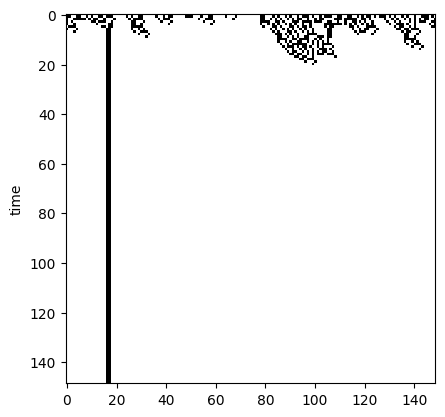

Average cell entropy: 0.149
1/1 [==============================] - 0s 20ms/step


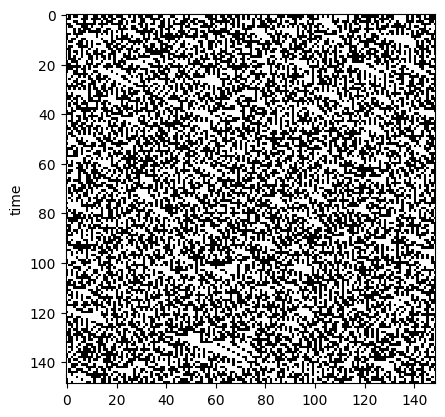

Average cell entropy: 0.995
583027286583041840534343241260613189
47620900320136553582958503417970777
535406386262905286951384737842642412
102.0


In [17]:
rand_rule = randint(0, 10**36)
path = run_ca(rand_rule, show=True)
img = keras.preprocessing.image.load_img(path, target_size=(149, 149))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
pred_rule = int(''.join([str(round(x)) for x in predictions[0]]))
run_ca(pred_rule, show=True)
print(pred_rule)
print(rand_rule)
print(pred_rule - rand_rule)
print(sum([abs(float(r) - float(l)) for r, l in zip(str(pred_rule), str(rand_rule))])/len(predictions))

Found 136 files belonging to 1 classes.
5/5 [==============================] - 0s 31ms/step
675336255463063551655343252261614445 987557347564184581887365383283806734


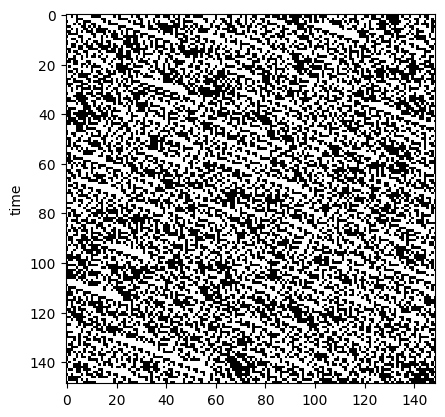

Average cell entropy: 0.990


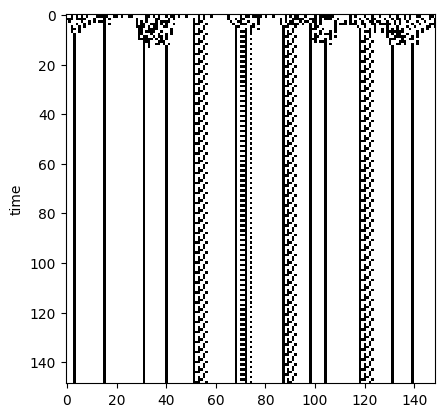

Average cell entropy: 0.228
0.39705882352941174


In [109]:
# validate model

# create validation dataset
validation_dataset = keras.preprocessing.image_dataset_from_directory("./val", image_size=(149, 149), batch_size=300, label_mode='int', labels=None)
imgs = []
for img in validation_dataset:
    imgs.append(img)
imgs[0]

# test a prediction on an image in the validation set
test_img = imgs
predictions = model.predict(test_img[:1])
pred_rule = int(''.join([str(round(x)) for x in predictions[0]]))
pred_label = int(''.join([str(round(x)) for x in labels[0]]))
print(pred_rule, pred_label)
run_ca(pred_rule, show=True)
run_ca(pred_label, show=True)
# print the average difference between the predicted rule and the actual rule
print(sum([abs(float(r) - float(l)) for r, l in zip(str(pred_rule), str(pred_label))])/len(predictions))

In [107]:
# get metrics on validation set
model.evaluate(imgs[0], labels[:len(imgs[0])])

5/5 [==============================] - 0s 28ms/step - loss: 13.4642 - mean_absolute_percentage_error: 238947264.0000


[13.464165687561035, 238947264.0]

In [ ]:
# model kidna works; create a checkpoint
model.save('model.h5')

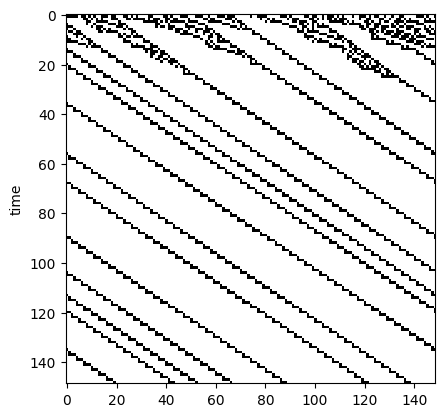

Average cell entropy: 0.530


'./img/876446246453163561765354262272605536/0.5295603967867395.png'

In [ ]:
run_ca(876446246453163561765354262272605536, show=True)